In [78]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import signal

In [79]:
read_folder = './clips/'
# subjects: 4001(E0, EC), 4032(E0, EP), 4191(E0, EP)
id = 'SC401100'
psg_id = id + 'E0'
hypnogram_id = id + 'EH'

channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']
channel = channels[1]
signal_path = os.path.join(read_folder, f'{psg_id}-PSG.edf')
label_path = os.path.join(read_folder, f'{hypnogram_id}-Hypnogram.edf')

In [80]:
# read EDF files
if 'edf_label' and 'edf_label' in globals():
    del edf_signal, edf_label
edf_signal = pyedflib.EdfReader(signal_path)
edf_label = pyedflib.EdfReader(label_path)

# read data
annotations = edf_label.readAnnotations()
start = edf_signal.getStartdatetime()
signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
data = []
for ch_idx, sig_name, freq in zip( range(len(signals)), signals, frequencies,):
    sig = edf_signal.readSignal(chn=ch_idx)
    idx = pd.date_range(  start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s") )
    data += [pd.Series(sig, index=idx, name=sig_name)]


In [81]:
# create DataFrames
annotations_df = pd.DataFrame(annotations)
annotations_df = annotations_df.T
annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
signal_df =pd.concat(data[0:2], axis=1)

In [82]:
signal_df['N1'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1'] = signal_df.apply(check_sleep_stage, axis=1)

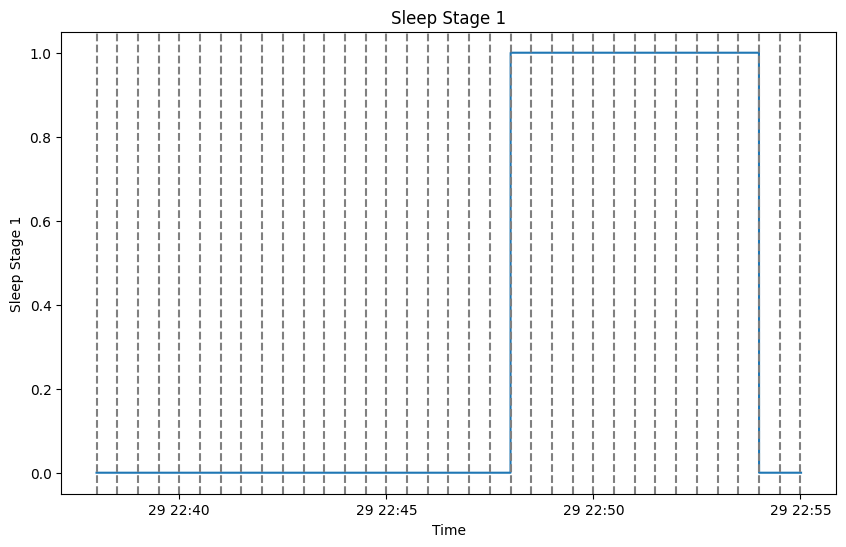

In [83]:
plt.figure(figsize=(10, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()
# plt.savefig('/fig/' + )

In [84]:
signal_df.shape

(102100, 3)

In [85]:
signals, frequencies

(['EEG Fpz-Cz',
  'EEG Pz-Oz',
  'EOG horizontal',
  'Resp oro-nasal',
  'EMG submental',
  'Temp rectal',
  'Event marker'],
 array([100., 100., 100.,   1.,   1.,   1.,   1.]))

In [86]:
n1_df = signal_df.loc[signal_df['N1'] == 1]
n1_df

,EEG Fpz-Cz,EEG Pz-Oz,N1
1989-03-29 22:48:00.000,-1.942857,0.677656,1
1989-03-29 22:48:00.010,-1.345055,3.117216,1
1989-03-29 22:48:00.020,-1.743590,6.821734,1
1989-03-29 22:48:00.030,-5.728938,2.032967,1
1989-03-29 22:48:00.040,-8.419048,0.316239,1
...,...,...,...
1989-03-29 22:53:59.950,3.536996,-1.129426,1
1989-03-29 22:53:59.960,3.437363,-2.394383,1
1989-03-29 22:53:59.970,0.846886,0.135531,1
1989-03-29 22:53:59.980,-3.437363,2.484737,1


In [87]:
n1_df.columns

Index(['EEG Fpz-Cz', 'EEG Pz-Oz', 'N1'], dtype='object')

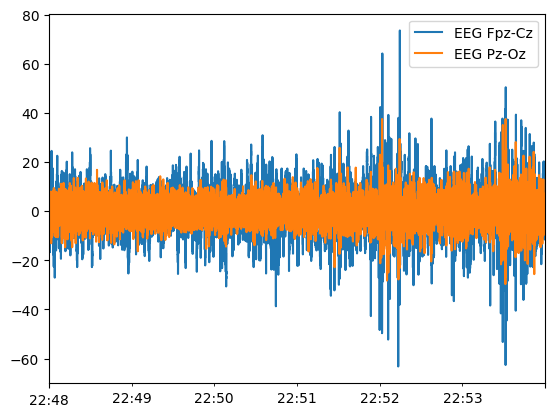

In [88]:
# Plot the DataFrame
# fig = plt.figure(figsize=(12, 12))

n1_df.plot(y=['EEG Fpz-Cz', 'EEG Pz-Oz'], kind='line')
plt.show()

In [89]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import pandas as pd
def lol(signal_df):
    num_columns = len(signal_df.columns)

    fig, axes = plt.subplots(num_columns, 1, figsize=(20, 12), sharex=True)

    # 迴圈遍歷每個欄位
    for i, column in enumerate(signal_df.columns):
        # 取得目前的軸
        ax = axes[i]

        # 繪製折線圖
        ax.plot(signal_df.index, signal_df[column])
        
        # 繪製虛線
        start_time = signal_df.index[0]
        end_time = signal_df.index[-1]
        interval = pd.Timedelta(seconds=30)
        current_time = start_time + interval
        while current_time < end_time:
            ax.axvline(x=current_time, linestyle='--', color='gray')
            current_time += interval

        # 設定軸的標籤
        ax.set_ylabel(column)
        loc = mdates.MinuteLocator(interval=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 設定圖表標題和共用 x 軸標籤
    fig.suptitle('Signal Visualization')
    axes[-1].set_xlabel('Time')

    # 調整子圖之間的間距
    plt.tight_layout()
    # 顯示圖表
    plt.show()


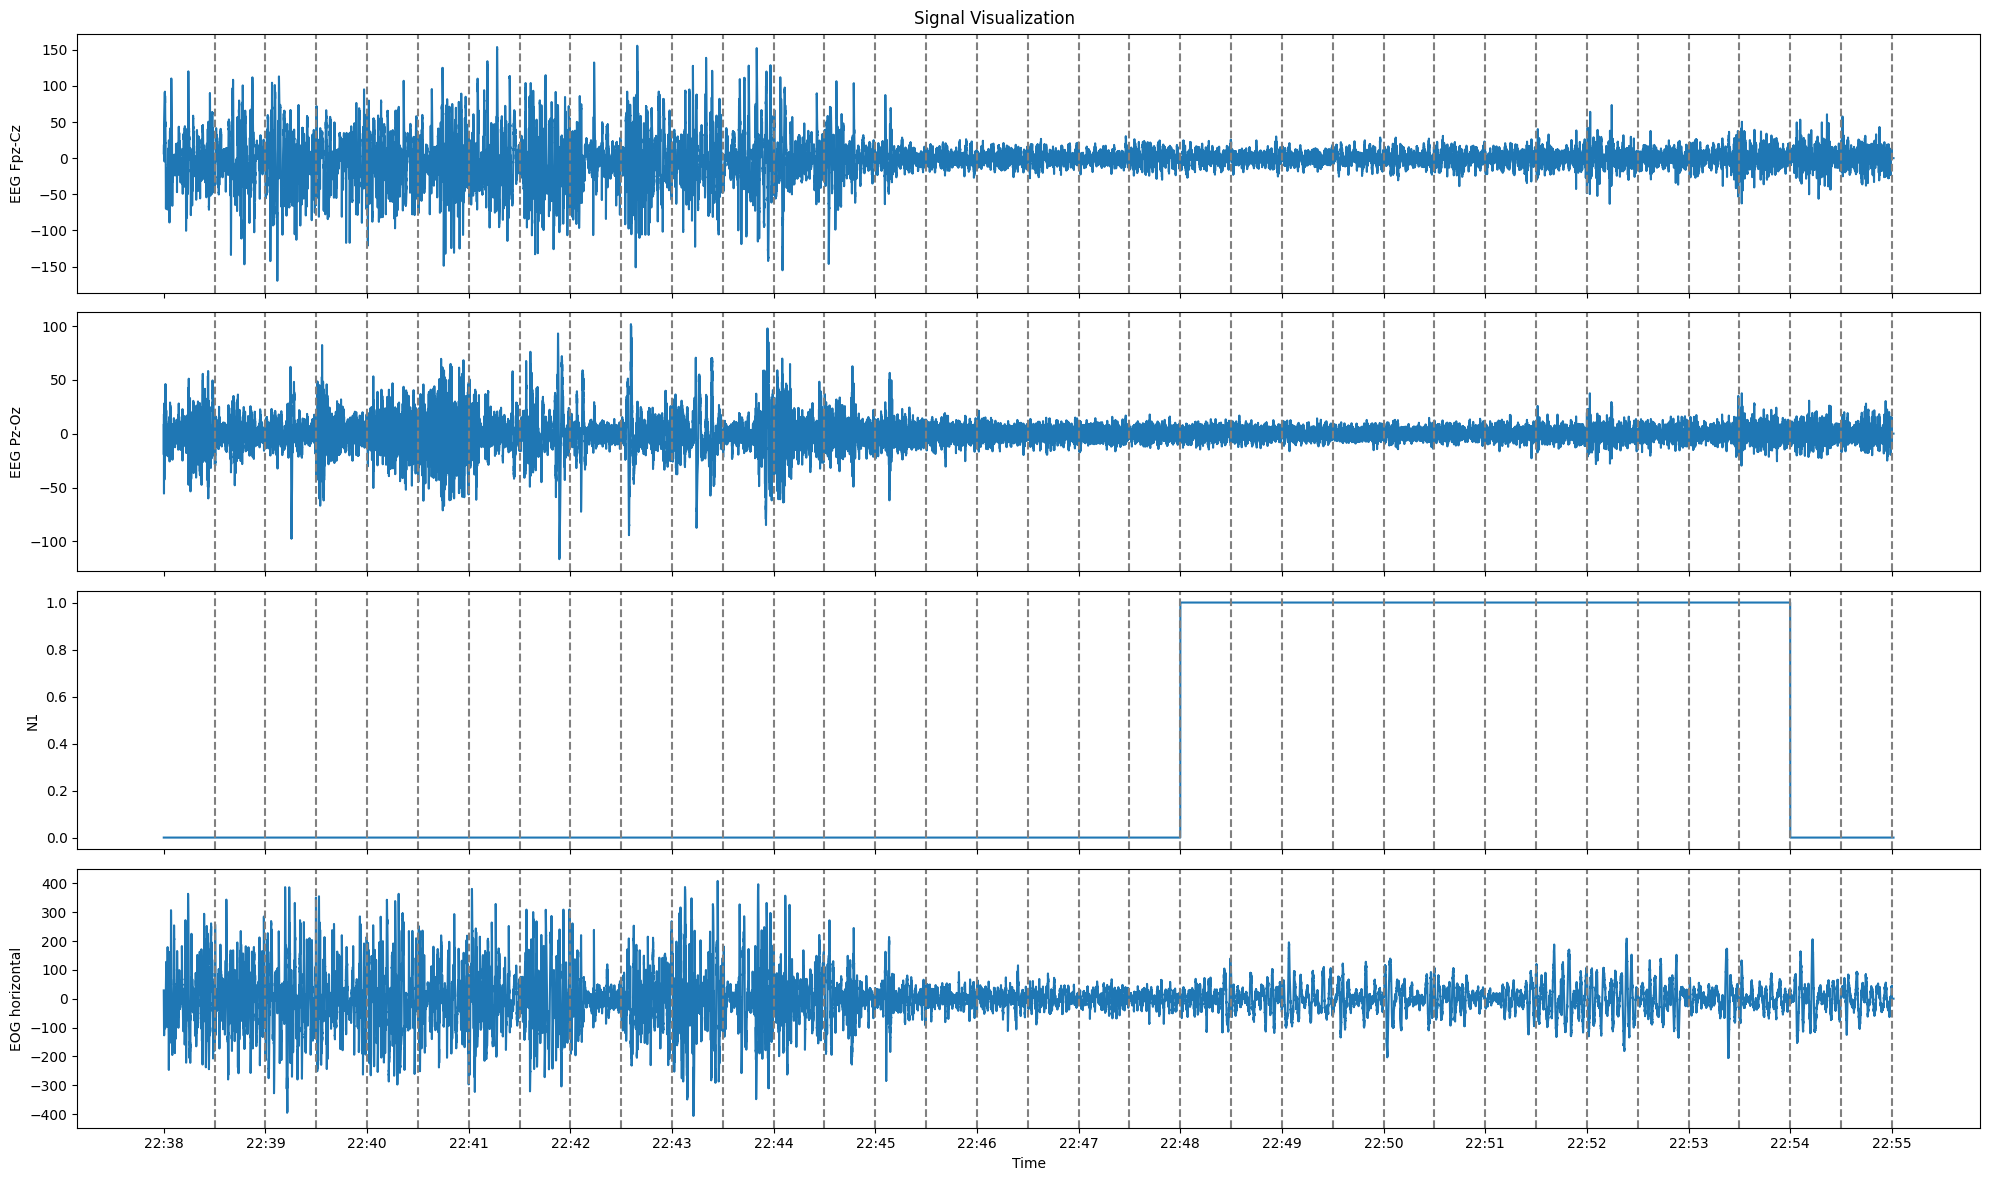

In [90]:
# 取得資料的欄位數量

# 設定圖表大小
signal_df_new = pd.concat([signal_df, data[2]], axis=1)
lol(signal_df_new)

In [91]:
# Define the frequency bands of interest
freq_bands = {'delta': (0.5, 4),
              'theta': (4, 8),
              'alpha': (8, 12),
              'beta': (12, 30)}

# Define the window size and step size
win_size = 10  # seconds
step_size = 2  # seconds

# Calculate the number of samples per window and step
# 100x3 1x4
# 100cyc/sec = 100 samples/sec
win_samples = int(win_size * frequencies[0])
step_samples = int(step_size * frequencies[0])

# Initialize the classification matrix
n_windows = int(np.ceil((signal_df.shape[0] - win_samples) / step_samples) + 1)
classif = np.zeros(n_windows)

# Loop over windows and classify based on criteria


In [92]:
n_windows

507

In [93]:
for i in range(n_windows):
    # Extract window data
    start = i * step_samples
    end = start + win_samples
    if end > signal_df.shape[0]:
        end = signal_df.shape[0]
    window = signal_df[start:end]
    print("Window",window.shape)

    # Calculate PSD for each frequency band
    psd = {}
    for name, (fmin, fmax) in freq_bands.items():
        freqs, psd[name] = signal.welch(window, fs=frequencies[0], nperseg=win_samples)
        print(freqs.shape, psd[name].shape)
        # Plot the PSD estimate
        mask = np.logical_and(freqs >= fmin, freqs < fmax)
        psd[name] = np.mean(psd[name][mask])
        freqs = freqs[:len(window)]
        # print(len(freqs), len(window))
        # print(name)
    # break
        # Calculate LAMF, VSW, and SEM
        lamf = (np.logical_and(window < 20, freqs > 10))
        
        diffs = np.diff(window) < -50
        diffs = np.append(0, diffs)
        vsw = np.mean(np.logical_and(window > 50, diffs))
        
        sem = np.mean(np.logical_and(window < 30, freqs < 3))
        print(lamf)
        print(lamf.shape)
        plt.show()
        break
    # Check criteria for N1
    if psd['alpha'] < 0.1 * np.sum(list(psd.values())):
        if np.any(np.logical_and(freqs >= 4, freqs <= 7)):
            classif[i] = 1
        elif vsw > 0.5:
            classif[i] = 1
        elif sem > 0.5:
            classif[i] = 1
    elif lamf > 0.5:
        classif[i] = 0

    # Print the current classification
    if i % 10 == 0:
        print('Window {}: {}'.format(i, 'N1' if classif[i] == 1 else 'Non-N1'))
    """
    To implement a sliding window approach for real-time data, you can modify the previous code to continuously update the classification based on a fixed window size and step size. Here's an example implementation:

    """

Window (1000, 3)
(2,) (1000, 2)


/home/jojo/mambaforge/envs/sleep-linear/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 1000 is greater than input length  = 3, using nperseg = 3
  warnings.warn('nperseg = {0:d} is greater than input length '


IndexError: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 2